In [1]:
import dgl
import torch.nn as nn
import torch
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from WordNetLemmatizeFix import WordNetLemmatizeFix
from nltk.corpus import inaugural
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /home/hp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# corpus = inaugural.raw('1789-Washington.txt')

In [8]:
corpus = open('testcorpus2.txt', 'r')
corpus = corpus.read()

In [9]:
# corpus = nltk.corpus.gutenberg.words(fileids='austen-emma.txt')
# corpus = ' '.join(tk for tk in corpus) 

In [10]:
# Tokenization
corpus = corpus.lower()
corpus = corpus.replace('"', '')
sent_token = nltk.sent_tokenize(corpus)
len(sent_token)

6345

In [11]:
lemm = WordNetLemmatizeFix()
corpus = lemm.lemmatize_return_txt(corpus)
corpus = lemm.lemmatize_return_txt(corpus)

In [82]:
from nltk.sentiment import SentimentIntensityAnalyzer
import math

def getSentimentScore(sent_tokens):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = []
    for sentence in sent_tokens:
        scores = sid.polarity_scores(sentence)
        sentiment_scores.append(scores['compound'])  # Compound score ranges from -1 to 1
    return sentiment_scores

def assignWeightsAndSents(NER_vec, sent_tokens):
    graph = nx.Graph()
    sentiment_scores = getSentimentScore(sent_tokens)  # Get sentiment scores for each sentence
    base = len(sent_tokens)
    bias_multiplier = 2
    for i, sent in enumerate(sent_tokens):
        for j, entity in enumerate(NER_vec):
            count = sent.count(entity)
            if count > 0:
                if bias_multiplier == 0:
                    bias_multiplier = 0.5
                else:
                    bias_multiplier = bias_multiplier - 0.01
                weight = math.sqrt(abs(count * sentiment_scores[i] + bias_multiplier))
                graph.add_node(entity)  # Add the entity as a node
                graph.add_node(i)  # Add the sentence index as a node
                graph.add_edge(entity, i, weight=weight)  # Add an edge with the adjusted weight
    return graph

In [83]:
doc = nlp(corpus)
entset = set()
NER_vec = {}
constant = False
while constant == False:
    txt = ''
    for e in doc.ents:
        txt = txt + e.text + ' '
    doc = nlp(txt)
    history_len = len(NER_vec)
    NER_vec = {}
    for e in doc.ents:
        NER_vec[e.text] = e.label_
    if history_len == len(NER_vec):
        constant = True
weights = assignWeightsAndSents(NER_vec, sent_token)
print(len(NER_vec), len(weights))

566 2039


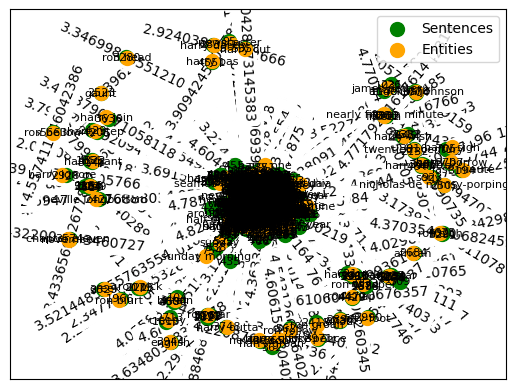

<Figure size 2000x2800 with 0 Axes>

In [84]:
def visualize(graph):
    pos = nx.spring_layout(graph)  # Positions nodes using Fruchterman-Reingold force-directed algorithm
    
    # Separate nodes into sentences and entities
    sentence_nodes = [node for node in graph.nodes if isinstance(node, int)]
    entity_nodes = [node for node in graph.nodes if isinstance(node, str)]
    
    # Draw sentence nodes (colored green) with smaller size
    nx.draw_networkx_nodes(graph, pos, nodelist=sentence_nodes, node_color='green', label='Sentences', node_size=100)
    
    # Draw entity nodes (colored orange) with smaller size
    nx.draw_networkx_nodes(graph, pos, nodelist=entity_nodes, node_color='orange', label='Entities', node_size=100)
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos)
    
    # Draw labels with smaller text size
    nx.draw_networkx_labels(graph, pos, font_size=8)
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    # Show the plot
    plt.legend()
    plt.figure(figsize=(20, 28))  # Larger figure size
    plt.show()

# Assuming 'weights' is your graph
visualize(weights)

In [85]:
pagerank_scores = nx.pagerank(weights)

sorted_sentences = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)
print_length = sorted_sentences
top_sentences = sorted_sentences[:10]
print(top_sentences, len(top_sentences))

[('one', 0.16528564079888117), ('ten', 0.030562027893393424), ('first', 0.017975798583046477), ('two', 0.01633391722612577), ('night', 0.015261519194553225), ('house', 0.013685889904616392), ('three', 0.013262403576779876), ('sec', 0.011370556428907542), ('filch', 0.009450603466609765), ('half', 0.008113786592146595)] 10


In [92]:
for item in top_sentences:
    if isinstance(item[0], int):  # Check if it's an integer (index)
        print(sent_token[item[0]])
    else:  # Otherwise, print the string itself
        print(item[0])

one the chessmen seemed to have been listening, because at these words a
knight, a bishop, and a castle turned their backs on the white pieces
and walked off the board, leaving three empty squares that harry, ron,
and hermione took.
one second -- to miss hermione granger... for the use of cool logic in the
face of fire, i award gryffindor house fifty points.
one harry made his way down to the end-of-year feast alone that night.
one harry
looked over her shoulder to read it:

danger lies before you, while safety lies behind,

two of us will help you, which ever you would find,

one among us seven will let you move ahead,

another will transport the drinker back instead,

two among our number hold only nettle wine,

three of us are killers, waiting bidden in line.
one seven bottles: three are poison; two are
wine; one will get us safely through the black fire, and one will get us
back through the purple.


In [93]:
'''
def assignWeightsAndSents(NER_vec, sent_tokens):
    graph = nx.Graph()
    for i, sent in enumerate(sent_tokens):
        for j, entity in enumerate(NER_vec):
            count = sent.count(entity)
            if count > 0:
                graph.add_node(entity)  # Add the entity as a node
                graph.add_node(i)  # Add the sentence index as a node
                graph.add_edge(entity, i, weight=count)  # Add an edge with the count as weight
    return graph
'''

'\ndef assignWeightsAndSents(NER_vec, sent_tokens):\n    graph = nx.Graph()\n    for i, sent in enumerate(sent_tokens):\n        for j, entity in enumerate(NER_vec):\n            count = sent.count(entity)\n            if count > 0:\n                graph.add_node(entity)  # Add the entity as a node\n                graph.add_node(i)  # Add the sentence index as a node\n                graph.add_edge(entity, i, weight=count)  # Add an edge with the count as weight\n    return graph\n'

In [94]:
authority_scores, hub_scores = nx.hits(weights)

sorted_authorities = sorted(authority_scores.items(), key=lambda x: x[1], reverse=True)
top_authorities = sorted_authorities[:10]

sorted_hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)
top_hubs = sorted_hubs[:10]

top_sentences = []
sentences_joined = 0
for authority_node, authority_score in top_authorities:
    for hub_node, hub_score in top_hubs:
        if isinstance(hub_node, int):
            sentence = sent_token[hub_node]
            combined_sentence = f"{authority_node} {sentence}"
            top_sentences.append((combined_sentence, authority_score * hub_score))
            sentences_joined += 1
            if sentences_joined >= 5:
                break
    if sentences_joined >= 5:
        break

# Now we will sort the top sentences by score
top_sentences = sorted(top_sentences, key=lambda x: x[1], reverse=True)

# Printing
for sentence, score in top_sentences:
    print(sentence, score)


5759 the chessmen seemed to have been listening, because at these words a
knight, a bishop, and a castle turned their backs on the white pieces
and walked off the board, leaving three empty squares that harry, ron,
and hermione took. 3.3950781896437055e-06
5759 second -- to miss hermione granger... for the use of cool logic in the
face of fire, i award gryffindor house fifty points. 3.327025791635468e-06
5759 harry made his way down to the end-of-year feast alone that night. 3.322482568304339e-06
5759 harry
looked over her shoulder to read it:

danger lies before you, while safety lies behind,

two of us will help you, which ever you would find,

one among us seven will let you move ahead,

another will transport the drinker back instead,

two among our number hold only nettle wine,

three of us are killers, waiting bidden in line. 3.3120179462869996e-06
5759 seven bottles: three are poison; two are
wine; one will get us safely through the black fire, and one will get us
back through t

In [95]:
def summarize_text(graph, top_n=5):
    sentence_scores = {}
    for node in graph.nodes:
        if isinstance(node, int):
            sentence_score = 0
            for neighbor, data in graph[node].items():
                sentence_score += data['weight']
            sentence_scores[node] = sentence_score

    top_sentences = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    summary = []
    for sentence_index, _ in top_sentences:
        summary.append(sent_token[sentence_index])
    
    return ' '.join(summary)

# Example usage
summary = summarize_text(weights, top_n=2)
print("Summary:", summary)


Summary: hopefully your heads are all a
little fuller than they were... you have the whole summer ahead to get
them nice and empty before next year starts....

now, as i understand it, the house cup here needs awarding, and the
points stand thus: in fourth place, gryffindor, with three hundred and
twelve points; in third, hufflepuff, with three hundred and fifty-two;
ravenclaw has four hundred and twenty-six and slytherin, four hundred
and seventy- two. choose, unless you wish to stay here forevermore,

to help you in your choice, we give you these clues four:

first, however slyly the poison tries to hide

you will always find some on nettle wine's left side;

second, different are those who stand at either end,

but if you would move onward, neither is your friend;

third, as you see clearly, all are different size,

neither dwarf nor giant holds death in their insides;

fourth, the second left and the second on the right

are twins once you taste them, though different at first sigh

In [96]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

# This function will finte tune sentences, like add punctuation marks and determiners
def fine_tune_sentences(summar, lim):
    sentences = nltk.sent_tokenize(summary)
    fine_tuned_sentences = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        tagged_words = nltk.pos_tag(words)
        fine_tuned_words = []
        i = 0
        for word, tag in tagged_words:
            i += 1
            if tag.__contains__('NN'):
                if tag.__contains__('NNP'):
                    pass
                else:
                    fine_tuned_words.append('the ' + word) 
            else:
                fine_tuned_words.append(word)
        fine_tuned_sentence = TreebankWordDetokenizer().detokenize(fine_tuned_words)
        fine_tuned_sentences.append(fine_tuned_sentence)
        if i > lim:
            break
    fine_tuned_summary = ' '.join(fine_tuned_sentences)
    
    return fine_tuned_summary

fine_tuned_summary = fine_tune_sentences(summary, 15)
print("Fine-tuned Summary:", fine_tuned_summary)

Fine-tuned Summary: hopefully your the heads are all a little the fuller than they were...you have the whole the summer ahead to get them nice and empty before next the year starts .... now, as i understand it, the the house the cup here needs the awarding, and the the points stand thus: in fourth the place, the gryffindor, with three the hundred and twelve the points; in third, the hufflepuff, with three hundred and fifty-two; the ravenclaw has four hundred and twenty-six and slytherin, four hundred and seventy- two.


In [91]:
from rouge import Rouge

rouge = Rouge()
reference_summary = """
Mr. Dursley, a well-off Englishman, notices strange happenings on his way to work one day. That night, Albus Dumbledore, the head of a wizardry academy called Hogwarts, meets Professor McGonagall, who also teaches at Hogwarts, and a giant named Hagrid outside the Dursley home. Dumbledore tells McGonagall that someone named Voldemort has killed a Mr. and Mrs. Potter and tried unsuccessfully to kill their baby son, Harry. Dumbledore leaves Harry with an explanatory note in a basket in front of the Dursley home.
Ten years later, the Dursley household is dominated by the Dursleys’ son, Dudley, who torments and bullies Harry. Dudley is spoiled, while Harry is forced to sleep in a cupboard under the stairs. At the zoo on Dudley’s birthday, the glass in front of a boa constrictor exhibit disappears, frightening everyone. Harry is later punished for this incident.
Mysterious letters begin arriving for Harry. They worry Mr. Dursley, who tries to keep them from Harry, but the letters keep arriving through every crack in the house. Finally, he flees with his family to a secluded island shack on the eve of Harry’s eleventh birthday. At midnight, they hear a large bang on the door and Hagrid enters. Hagrid hands Harry an admissions letter to the Hogwarts School of Witchcraft and Wizardry. Harry learns that the Dursleys have tried to deny Harry’s wizardry all these years.
The next day, Hagrid takes Harry to London to shop for school supplies. First they go to the wizard bank, Gringotts, where Harry learns that his parents have left him a hefty supply of money. They shop on the wizards’ commercial street known as Diagon Alley, where Harry is fitted for his school uniform. Harry buys books, ingredients for potions, and, finally, a magic wand—the companion wand to the evil Voldemort’s.
A month later, Harry goes to the train station and catches his train to Hogwarts on track nine and three quarters. On the train, Harry befriends other first-year students like Ron Weasley and Hermione Granger, a Muggle girl chosen to attend Hogwarts. At school, the first-years take turns putting on the “Sorting Hat” to find out in which residential house they will live. Harry fears being assigned to the sinister Slytherin house, but he, Ron, and Hermione end up in the noble Gryffindor house.
As the school year gets underway, Harry discovers that his Potions professor, Snape, does not like him. Hagrid reassures Harry that Snape has no reason to dislike him. During their first flying lesson on broomsticks, the students are told to stay grounded while the teacher takes an injured boy named Neville to the hospital. Draco Malfoy, a Slytherin bully, snatches Neville’s prized toy and flies off with it to the top of a tree. Harry flies after him. Malfoy throws the ball in the air, and Harry speeds downward, making a spectacular catch. Professor McGonagall witnesses this incident. Instead of punishing Harry, she recommends that he play Quidditch, a much-loved game that resembles soccer played on broomsticks, for Gryffindor. Later that day, Malfoy challenges Harry to a wizard’s duel at midnight. Malfoy doesn’t show up at the appointed place, and Harry almost gets in trouble. While trying to hide, he accidentally discovers a fierce three-headed dog guarding a trapdoor in the forbidden third-floor corridor.
On Halloween, a troll is found in the building. The students are all escorted back to their dormitories, but Harry and Ron sneak off to find Hermione, who is alone and unaware of the troll. Unwittingly, they lock the troll in the girls’ bathroom along with Hermione. Together, they defeat the troll. Hermione tells a lie to protect Harry and Ron from being punished. During Harry’s first Quidditch match, his broom jerks out of control. Hermione notices Snape staring at Harry and muttering a curse. She concludes that he is jinxing Harry’s broom, and she sets Snape’s clothes on fire. Harry regains control of the broom and makes a spectacular play to win the Quidditch match.
For Christmas, Harry receives his father’s invisibility cloak, and he explores the school, unseen, late at night. He discovers the Mirror of Erised, which displays the deepest desire of whoever looks in it. Harry looks in it and sees his parents alive. After Christmas, Harry, Ron, and Hermione begin to unravel the mysterious connection between a break-in at Gringotts and the three-headed guard dog. They learn that the dog is guarding the Sorcerer’s Stone, which is capable of providing eternal life and unlimited wealth to its owner and belongs to Nicolas Flamel, Dumbledore’s old partner.
A few weeks later, Hagrid wins a dragon egg in a poker game. Because it is illegal to own dragons, Harry, Ron, and Hermione contact Ron’s older brother, who studies dragons. They arrange to get rid of the dragon but get caught. Harry, Ron, and Hermione are severely punished, and Gryffindor is docked 150 points. Furthermore, part of their punishment is to go into the enchanted forest with Hagrid to find out who has been killing unicorns recently. In the forest, Harry comes upon a hooded man drinking unicorn blood. The man tries to attack Harry, but Harry is rescued by a friendly centaur who tells him that his assailant was Voldemort. Harry also learns that it is Voldemort who has been trying to steal the Sorcerer’s Stone.
Harry decides that he must find the stone before Voldemort does. He, Ron, and Hermione sneak off that night to the forbidden third-floor corridor. They get past the guard dog and perform many impressive feats as they get closer and closer to the stone. Harry ultimately finds himself face to face with Quirrell, who announces that Harry must die. Knowing that Harry desires to find the stone, Quirrell puts Harry in front of the Mirror of Erised and makes him state what he sees. Harry sees himself with the stone in his pocket, and at that same moment he actually feels it in his pocket. But he tells Quirrell that he sees something else. A voice tells Quirrell that the boy is lying and requests to speak to Harry face to face. Quirrell removes his turban and reveals Voldemort’s face on the back of his head. Voldemort, who is inhabiting Quirrell’s body, instructs Quirrell to kill Harry, but Quirrell is burned by contact with the boy. A struggle ensues and Harry passes out.
When Harry regains consciousness, he is in the hospital with Dumbledore. Dumbledore explains that he saved Harry from Quirrell just in time. He adds that he and Flamel have decided to destroy the stone. Harry heads down to the end-of-year banquet, where Slytherin is celebrating its seventh consecutive win of the house championship cup. Dumbledore gets up and awards many last-minute points to Gryffindor for the feats of Harry and his friends, winning the house cup for Gryffindor. Harry returns to London to spend the summer with the Dursleys.
"""
scores = rouge.get_scores(fine_tuned_summary, reference_summary, avg=True, ignore_empty=True)
print(scores)
scores = rouge.get_scores(summary, reference_summary, avg=True, ignore_empty=True)
print(scores)

{'rouge-1': {'r': 0.04452690166975881, 'p': 0.4067796610169492, 'f': 0.0802675567498686}, 'rouge-2': {'r': 0.004897159647404506, 'p': 0.06172839506172839, 'f': 0.009074408801338146}, 'rouge-l': {'r': 0.04081632653061224, 'p': 0.3728813559322034, 'f': 0.07357859353916626}}
{'rouge-1': {'r': 0.07050092764378478, 'p': 0.3140495867768595, 'f': 0.11515151215707077}, 'rouge-2': {'r': 0.007835455435847209, 'p': 0.049689440993788817, 'f': 0.01353637666547892}, 'rouge-l': {'r': 0.06493506493506493, 'p': 0.2892561983471074, 'f': 0.1060606030661617}}
